# Modeling

In this notebook, we will train a Neural Network model to forecast demand based on the `Historical_Product_Demand_per_Product.csv` on a monthly level. In the first part, we train a model and validate it on a hold-out set. Later, we will use the trained model to forecast 3 months into the future, given 12 months of data. 

# LSTM on Deseasonalized and Detrended Time Series


This approach is adapted from the state-of-the-art solutions that won CIF 2016 short time series forecasting competition and NNS 2018 time series forecasting competition.

The paper is released on arXiv: [Forecasting Across Time Series Databases using Recurrent Neural Networks on Groups of Similar Series: A Clustering Approach](https://arxiv.org/abs/1710.03222)

It takes advantage of both traditional statistical methods and novel deep learning methods through the following steps: <br>
<br>
<center> Apply STL decomposition (Seasonal Trend Decomposition using Loess) on each time series to <b> split seasonality, trend, and remainder </b>. </center>
$$\downarrow$$
<center> Reshape deseasonalized time series (trend + remainder) using moving window, with an input window and an output window. </center>
$$\downarrow$$
<center> Remove the trend from each sample (one input window + output window) by deducting <b> the trend of the last observed time point </b> from the given sample. </center>
$$\downarrow$$
<center> Stack samples constructed from all time series together to learn a <b>global</b> model. </center>
$$\downarrow$$
<center> Train a LSTM model with the deseasonalized and detrended data. </center>
$$\downarrow$$
<center> <b>Reassemble the final prediction </b> by combining the model prediction and seasonality (re-occurring) & trend (trend of the last observed time point in input). </center>

## Step 0: Install and Import Packages

Packages like `statsmodels` and `stldecompose` need to be installed if they are not already present in the environment.

In [14]:
!pip install statsmodels==0.10.1 -q

In [15]:
!pip install stldecompose -q

In [16]:
#Install a specific version of tensor flow, otherwise Cell 22 will need to fix the model.fit call to remove baselogger from the callbacks - callbacks=[baselogger, checkpointer]
!pip install tensorflow==2.1.1 -q

In [17]:
import tensorflow as tf
tf.__version__

'2.1.0'

In [18]:
# There may be some deprecation warnings, but they can be ignored.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import copy
import time
import pandas.testing as tm
from stldecompose import decompose
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Activation, LSTM, GaussianNoise
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import BaseLogger, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.optimizers import RMSprop

import warnings
warnings.filterwarnings('ignore')

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

%matplotlib inline

## Step 1: Load and Prepare Data

Dataset is expected to contain a time series in each column i.e., shape of dataset should be `len(time_series) x no of time series`

In [19]:
df = pd.read_csv('/project_data/data_asset/Historical_Product_Demand_per_Product.csv')
df.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)
df.set_index('Date', inplace=True)
df.index = pd.to_datetime(df.index)

df.head()

Product_0001_W2  Product_0003_W2  Product_0004_W2  \
Date                                                            
2012-01-01              0.0              0.0              0.0   
2012-01-02              0.0              0.0              0.0   
2012-01-03              0.0              0.0              0.0   
2012-01-04              0.0              0.0              0.0   
2012-01-05            100.0              0.0              0.0   

            Product_0005_W2  Product_0006_W2  Product_0007_W2  \
Date                                                            
2012-01-01              0.0              0.0              0.0   
2012-01-02              0.0              0.0              0.0   
2012-01-03              0.0              0.0              0.0   
2012-01-04              0.0              0.0              0.0   
2012-01-05              0.0              0.0              0.0   

            Product_0008_W2  Product_0009_W2  Product_0010_W2  \
Date                                                            
2012-01-01              0.0              0.0              0.0   
2012-01-02              0.0              0.0              0.0   
2012-01-03              0.0              0.0              0.0   
2012-01-04              0.0              0.0              0.0   
2012-01-05           3000.0              0.0              0.0   

            Product_0011_W2  ...  Product_2138_W1  Product_2142_W1  \
Date                         ...                                     
2012-01-01              0.0  ...              0.0              0.0   
2012-01-02              0.0  ...              0.0              0.0   
2012-01-03              0.0  ...            144.0              0.0   
2012-01-04              0.0  ...            350.0              0.0   
2012-01-05           1400.0  ...              0.0              0.0   

            Product_2144_W1  Product_2147_W1  Product_2164_W1  \
Date                                                            
2012-01-01              0.0              0.0              0.0   
2012-01-02              0.0              0.0              0.0   
2012-01-03              0.0              0.0              0.0   
2012-01-04              0.0              0.0              0.0   
2012-01-05              0.0              0.0              0.0   

            Product_2165_W1  Product_2166_W1  Product_2167_W1  \
Date                                                            
2012-01-01              0.0              0.0              0.0   
2012-01-02              0.0              0.0              0.0   
2012-01-03              0.0              0.0              0.0   
2012-01-04             10.0              0.0              0.0   
2012-01-05              0.0              0.0             17.0   

            Product_2168_W1  Product_2169_W1  
Date                                          
2012-01-01              0.0              0.0  
2012-01-02              0.0              0.0  
2012-01-03              0.0              0.0  
2012-01-04              0.0              0.0  
2012-01-05              0.0              0.0  

[5 rows x 2849 columns]

In [20]:
df.shape

(1836, 2849)

As the dataset above is daily data, we convert it into monthly data and remove the last month as it'll be incomplete

In [21]:
df = df.resample('MS').sum()

In [22]:
df.shape

(61, 2849)

In [23]:
df = df.iloc[:-1]

## Step 2: STL Decomposition

The function `stl_py` takes a time series and breaks it into season, trend, and residuals. You can read more on STL Decomposition [here](https://en.wikipedia.org/wiki/Decomposition_of_time_series).

In [24]:
def stl_py(series, period = 12, **kwargs):
    '''
    Decompose a time series into seasonal, trend and irregular components using loess,
    acronym STL.

    params:
        series: a time series

        period: the number of observations per “cycle”
        (monthly data = 12, weekly data = 5 or 7, daily data = 30, hourly data = 24)
    '''
    
    df = pd.DataFrame()
    decomposed = decompose(series, period=period)
    df['observed'] = series
    df['trend'] = decomposed.trend
    df['seasonal'] = decomposed.seasonal
    df['residuals'] = decomposed.resid
    return df

## Step 3: Create Training and Validation Sets by Moving Window Approach

To build and evaluate the model we would need to split it into training and validation sets. Since we are converting time series into these sets, we adopt the rolling window approach.

### Define Input Window Size and Output Window Size (Forecasting Horizon)

In [25]:
input_size = 12
output_size = 3

### Generate the Training and Test Sets

In the cell below we create the training and validation sets. Some transformations we perform before doing that are: 

- Remove NAs from the series
- Perform log transformation
- Deseasonalize the series 
- Detrend the series 

In [26]:
train_list = []
val_list = []
season_train_list = []
season_val_list = []

colnames_input = ['i' + str(i) for i in range(input_size)]
colnames_output = ['o' + str(i) for i in range(output_size)]
colnames_season = ['s' + str(i) for i in range(output_size)]

colnames = ['ts_name']
colnames.extend(colnames_input)
colnames.extend(colnames_output)

colnames_s = ['ts_name', 'level']
colnames_s.extend(colnames_season)

for validation in [False, True]:
    if not validation:
        print('Generating Training Set')
    else:
        print('Generating Validation Set')
        
    for tsname in tqdm(df.columns.tolist()):
        ## select the current time series
        y = df.loc[:, tsname].values

        # remove NAs from the series - this is implemented in the original R script by the author, but we may change it to a more meaningful imputation
        y = y[~np.isnan(y)] 

        # log transform
        # Note: Log is undefined for values < 0. So we will make all values less than 0 as a 1.
        y = np.where(y > 0, y, 1)
        y = np.log(y)

        n = len(y)

        if not validation:
            n = n - output_size
            y = y[0:n]

        ## deseasonalize
        try:
            sstl = stl_py(y, frequency=12)

            # column nn_vect is the deseasonalized series
            stlAdj = pd.DataFrame({'seasonal_vect': sstl['seasonal'], 
                                   'nnLevels': sstl['trend'], 
                                   'nn_vect': sstl['trend'] + sstl['residuals']})
        except:
            stlAdj = pd.DataFrame({'sessonal_vect': np.zeros(n), 'nnlevels': y, 'nn_vect': y})

        val_temp_list = []
        season_temp_list = []
        ## detrend
        # variable inn points to the last observed value, i.e., the last one in your input window
        for inn in range (input_size-1, n-output_size) :
            # obtain the current trend (a.k.a. level) from the last observed value
            level = stlAdj.loc[inn, 'nnLevels']

            # detrend input series by removing the current trend/level from the current deseasonalized input series (nn_vect)
            ts_i = stlAdj.loc[range(inn-input_size+1, inn+1), 'nn_vect'] - level

            # detrend output series by removing the current trend/level from the current deseasonalized output series (nn_vect)
            ts_o = stlAdj.loc[range(inn+1, inn+output_size+1), 'nn_vect'] - level

            # keep the seasonality values for the current output window
            ts_s = stlAdj.loc[range(inn+1, inn+output_size+1), 'seasonal_vect']

            ## write out the current window of input/output/season
            res = [tsname]
            res.extend(ts_i.tolist())
            res.extend(ts_o.tolist())
            res_season = [tsname]
            res_season.append(level)
            res_season.extend(ts_s.tolist())
            if not validation:
                # add to train
                train_list.append(res)
                season_train_list.append(res_season)
            else:
                # add to val
                val_temp_list.append(res)
                # add seasonality
                season_temp_list.append(res_season)
                
        # add only actual validation rows to the list
        val_list.extend(val_temp_list[-output_size:])
        season_val_list.extend(season_temp_list[-output_size:])


df_train = pd.DataFrame(train_list, columns=colnames)
df_val = pd.DataFrame(val_list, columns=colnames)
df_season_train = pd.DataFrame(season_train_list, columns=colnames_s)
df_season_val = pd.DataFrame(season_val_list, columns=colnames_s)

# Make sure there are no null values in set"
assert df_val.isnull().sum().sum() == 0, "There are null values in your validation set"
assert df_train.isnull().sum().sum() == 0, "There are null values in your train set"

Generating Training Set



Generating Validation Set


In [27]:
df_train.head()

ts_name        i0        i1        i2        i3        i4  \
0  Product_0001_W2  0.382081  0.408799  0.181680  0.154715 -0.162189   
1  Product_0001_W2  0.434708  0.207589  0.180624 -0.136280  1.026559   
2  Product_0001_W2  0.233100  0.206135 -0.110769  1.052070 -0.047361   
3  Product_0001_W2  0.231572 -0.085332  1.077507 -0.021923  0.526660   
4  Product_0001_W2 -0.059770  1.103069  0.003639  0.552222 -0.055230   

         i5        i6        i7        i8        i9       i10       i11  \
0  1.000650 -0.098781  0.449802 -0.157649  0.582884  0.163445 -0.761780   
1 -0.072872  0.475712 -0.131740  0.608793  0.189355 -0.735871 -0.144078   
2  0.501223 -0.106229  0.634304  0.214866 -0.710360 -0.118567 -1.006118   
3 -0.080792  0.659741  0.240303 -0.684923 -0.093130 -0.980681 -0.467400   
4  0.685303  0.265865 -0.659361 -0.067568 -0.955119 -0.441838  0.005820   

         o0        o1        o2  
0 -0.169987 -1.057538 -0.544257  
1 -1.031629 -0.518348 -0.070690  
2 -0.492837 -0.045179 -0.206079  
3 -0.019742 -0.180642 -0.914923  
4 -0.155080 -0.889361  0.217213

In [28]:
df_val.head()

ts_name        i0        i1        i2        i3        i4  \
0  Product_0001_W2 -0.612244 -0.144207 -0.241324 -0.401643 -0.138082   
1  Product_0001_W2 -0.153906 -0.251023 -0.411342 -0.147781 -0.020430   
2  Product_0001_W2 -0.261184 -0.421503 -0.157942 -0.030591 -0.362449   
3  Product_0003_W2  0.204084 -0.106852 -0.265948  0.122573 -0.174419   
4  Product_0003_W2 -0.092831 -0.251927  0.136595 -0.160397 -0.221105   

         i5        i6        i7        i8        i9       i10       i11  \
0 -0.010731 -0.342589  0.353506  0.013117  0.917312  0.415076 -0.328024   
1 -0.352288  0.343807  0.003418  0.907613  0.405377 -0.337723 -0.111118   
2  0.333645 -0.006744  0.897452  0.395215 -0.347884 -0.121279  0.098296   
3 -0.235126  0.304146  0.166802 -0.382783 -0.629417 -0.425437 -0.580608   
4  0.318167  0.180823 -0.368762 -0.615396 -0.411416 -0.566587  0.329331   

         o0        o1        o2  
0 -0.101419  0.118157 -0.033684  
1  0.108458 -0.043383 -2.490783  
2 -0.053545 -2.500945  0.065201  
3  0.315310  0.704078  0.070524  
4  0.718099  0.084546  0.501238

## Step 4: Reshape Datasets for Input to LSTM Model

Since an LSTM model expects data to be three dimensional, we reshape our data frames to fit that dimensionality.

In [29]:
X_train = df_train.iloc[:, 1:(input_size+1)].values.reshape(df_train.shape[0], input_size, 1)
X_val = df_val.iloc[:,1:(input_size+1)].values.reshape(df_val.shape[0], input_size, 1)

y_train = df_train.iloc[:, -output_size:].values
y_val = df_val.iloc[: , -output_size:].values

print('Shape of training data : ', X_train.shape, y_train.shape)
print('Shape of validation data : ' , X_val.shape, y_val.shape)

Shape of training data :  (122507, 12, 1) (122507, 3)
Shape of validation data :  (8547, 12, 1) (8547, 3)


## Step 5: LSTM Model Definition and Training

In this section we define our LSTM model specifics.

In [30]:
def plot_history(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(loss) + 1)

    plt.figure(figsize=(6, 5))
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

We create an LSTM model with the following specifics: 

`LEARNING_RATE` = 3e-4 <br>
`BATCH_SIZE` = 512 <br>
`NUM_EPOCHS` = 20 <br>
<br>
`Loss`= Mean Squared Error <br>
`Optimizer` = Adam <br>
<br>
`Layer 1` = 512 Nodes <br>
`Layer 2` = Gaussian Noise Regularization <br>
`Layer 3` = Dense Layer = Shape of the Output Expected <br>
<br>
These can be updated by the user based on their needs.

In [31]:
# There may be some deprecation warnings as the model trains, but they can be ignored.

LEARNING_RATE = 3e-4
BATCH_SIZE = 512
NUM_EPOCHS = 20

ver = '1'
device = 'CPU'
directory = '/project_data/data_asset/'
path_model = directory + 'Model_LSTM_' + device + '_Weights_' + ver + '.hdf5'

rnnkeras = Sequential()

rnnkeras.add(LSTM(512, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False, recurrent_dropout=0.3))
rnnkeras.add(GaussianNoise(0.1))
rnnkeras.add(Dense(y_train.shape[1]))

baselogger = BaseLogger()
checkpointer = ModelCheckpoint(filepath=path_model, verbose=1, save_best_only=True)

adam = Adam(lr=LEARNING_RATE)

rnnkeras.compile(loss='mean_squared_error', optimizer='adam')

print(rnnkeras.summary())

time_s = time.time()
history = rnnkeras.fit(X_train, y_train,
                        batch_size=BATCH_SIZE,
                        epochs=NUM_EPOCHS,
                        verbose=1,
                        shuffle=True,
                        validation_data=(X_val, y_val),
                        callbacks=[baselogger, checkpointer]
)
time_e = time.time() - time_s
print("\nTook %0.2f s" %(time_e))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 512)               1052672   
_________________________________________________________________
gaussian_noise (GaussianNois (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 3)                 1539      
Total params: 1,054,211
Trainable params: 1,054,211
Non-trainable params: 0
_________________________________________________________________
None
Train on 122507 samples, validate on 8547 samples
Epoch 1/20
122368/122507 [============================>.] - ETA: 1s - loss: 2.9625
Epoch 00001: val_loss improved from inf to 2.92446, saving model to /project_data/data_asset/Model_LSTM_CPU_Weights_1.hdf5
122507/122507 [==============================] - 1179s 10ms/sample - loss: 2.9616 - val_loss: 2.9245
Epoch 2/20
122

After training we can take a look at the training and validation loss to find signs of model overfitting. 

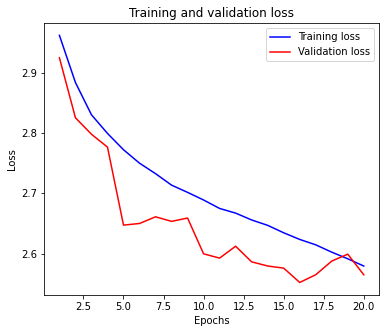

In [32]:
plot_history(history)

## Step 6: Inference Stage

Once we have finalized the model, we load it back and prepare the data for inferences.

In [33]:
path_model = '/project_data/data_asset/Model_LSTM_CPU_Weights_1.hdf5'

We add back level and seasonality to the data.

In [34]:
# reload the best model
rnnkeras = load_model(path_model)

df_final_train = copy.deepcopy(df_season_train)
df_final_val = copy.deepcopy(df_season_val)

# Add level (2nd column, index 1) and seasonality
for idx_col in range(2, df_season_train.shape[1]):
    df_final_train.iloc[:, idx_col] += df_final_train.iloc[:, 1]
    df_final_val.iloc[:, idx_col] += df_final_val.iloc[:, 1]

df_final_train.columns = colnames_s
df_final_val.columns = colnames_s

## Step 7: Make Test Predictions

Once we have the data in its final form, we can use the model to generate predictions for some unseen test set.

In [ ]:
# Make predictions on both train and validation sets
train_pred_raw = pd.DataFrame(rnnkeras.predict(X_train), columns=colnames_output)
val_pred_raw = pd.DataFrame(rnnkeras.predict(X_val), columns=colnames_output)

# Calculate the actual values back from the transformed values by adding the seasonality and doing exponential
actual_train = np.exp(df_final_train.loc[:, colnames_season].values + df_train.loc[:, colnames_output].values)
actual_val = np.exp(df_final_val.loc[:, colnames_season].values + df_val.loc[:, colnames_output].values)

pred_train = np.exp(df_final_train.loc[:, colnames_season].values + train_pred_raw.loc[:, colnames_output].values)
pred_val = np.exp(df_final_val.loc[:, colnames_season].values + val_pred_raw.loc[:, colnames_output].values)

## Step 8: Calculate Metrics

We also evaluate performance of the model using metrics of choice. In this case we use sMAPE - Symmetric Mean Absolute Percentage Error. You can read more [here](https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error). 

In [ ]:
# Function to calculate sMAPE on moving windows
def smape(A, F):
    """A - actuals, F - forecasted"""
    return 100 * np.mean(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [ ]:
print('Train sMAPE: {:.4f}'.format(smape(actual_train, pred_train)))

print('  Val sMAPE: {:.4f}'.format(smape(actual_val, pred_val)))

## Step 9: Transform Predictions back to `pid` Level

After getting forecasts at the rolling window level, we need to transform it back to product ID level to make the forecasts usable. 

In [ ]:
forecasts = {}
for pid in df.columns.tolist():
    pid_df = pred_val[df_val[df_val['ts_name'] == pid].index.tolist()]
    forecasts_pid = []
    forecasts_pid += pid_df[:, 0].tolist()
    forecasts_pid += pid_df[-1, 1:].tolist()
    forecasts[pid] = forecasts_pid

forecasts_df = pd.DataFrame(forecasts)

forecasts_df.index = df.index[-len(forecasts_df):]

forecasts_df.head()

## Step 10: Visualize Test Forecasts for a Few `pids`

We can also visualize the forecasts for some product IDs. Here we visualize 10.

In [ ]:
n_viz = 10 # no of pids to visualize

for pid in df.columns.tolist()[:n_viz]:
    plt.figure(figsize=(20, 8))
    plt.plot(df[pid], label='Actual')
    plt.plot(forecasts_df[pid], c='r', label='Predicted')
    plt.title('PID: ' + str(pid))
    plt.xlabel('Date')
    plt.ylabel('Booked_Quantity')
    plt.legend()

# Generate Forecasts for the Next 3 Months

Once we have the final model trained and validated, we can use it to generate future forecasts.

### Generate Test Set

We apply same steps as training phase to prepare the data set for final inference phase.

In [ ]:
df_last_year = df.loc[df.index[-12]:, :]
df_last_year

In [ ]:
test_list = []
season_test_list = []

colnames_input = ['i' + str(i) for i in range(input_size)]
colnames_season = ['s' + str(i) for i in range(output_size)]

colnames = ['ts_name']
colnames.extend(colnames_input)

colnames_s = ['ts_name', 'level']
colnames_s.extend(colnames_season)

for tsname in tqdm(df_last_year.columns.tolist()):
    ## select the current time series
    y = df_last_year.loc[:, tsname].values

    # remove NAs from the series - this is implemented in the original R script by the author, but we may change it to a more meaningful imputation
    y = y[~np.isnan(y)] 

    # log transform
    # Note: Log is undefined for values < 0. So we will make all values less than 0 as a 1.
    y = np.where(y > 0, y, 1)
    y = np.log(y)

    n = len(y)

    ## deseasonalize
    try:
        sstl = stl_py(y, frequency=12)

        # column nn_vect is the deseasonalized series
        stlAdj = pd.DataFrame({'seasonal_vect': sstl['seasonal'], 
                               'nnLevels': sstl['trend'], 
                               'nn_vect': sstl['trend'] + sstl['residuals']})
    except:
        stlAdj = pd.DataFrame({'sessonal_vect': np.zeros(n), 'nnlevels': y, 'nn_vect': y})
    
    ## detrend
    
    # variable inn points to the last observed value, i.e., the last one in your input window
    
    for inn in range (input_size-1, n) :
        # obtain the current trend (a.k.a. level) from the last observed value
        level = stlAdj.loc[inn, 'nnLevels']

        # detrend input series by removing the current trend/level from the current deseasonalized input series (nn_vect)
        ts_i = stlAdj.loc[range(inn-input_size+1, inn+1), 'nn_vect'] - level
        
        # keep the seasonality values for the current output window
        ts_s = stlAdj.loc[range(inn-output_size, inn), 'seasonal_vect']

        ## write out the current window of input
        res = [tsname]
        res.extend(ts_i.tolist())

        res_season = [tsname]
        res_season.append(level)
        res_season.extend(ts_s.tolist())

        # add to test
        test_list.append(res)
        season_test_list.append(res_season)


df_test = pd.DataFrame(test_list, columns=colnames)
df_season_test = pd.DataFrame(season_test_list, columns=colnames_s)

# Make sure there are no null values in set"
assert df_test.isnull().sum().sum() == 0, "There are null values in your test set"

In [ ]:
df_test.head()

## Step 11: Make Predictions

Once we have the data in the expected format, we make our forecasts.

In [ ]:
X_test = df_test.iloc[:, 1:(input_size+1)].values.reshape(df_test.shape[0], input_size, 1)

df_final_test = copy.deepcopy(df_season_test)

# Add level (2nd column, index 1) and seasonality
for idx_col in range(2, df_season_test.shape[1]):
    df_final_test.iloc[:, idx_col] += df_final_test.iloc[:, 1]

df_final_test.columns = colnames_s

test_pred_raw = pd.DataFrame(rnnkeras.predict(X_test), columns=colnames_output)

test_pred = np.exp(df_final_test.loc[:, colnames_season].values + test_pred_raw.loc[:, colnames_output].values)

Again, the forecasts need to be transformed to the product ID level.

In [ ]:
forecasts = {}

for pid in df_last_year.columns.tolist():
    pid_df = test_pred[df_test[df_test['ts_name'] == pid].index.tolist()]
    forecasts_pid = []
    forecasts_pid += pid_df[:, 0].tolist()
    forecasts_pid += pid_df[-1, 1:].tolist()
    forecasts[pid] = forecasts_pid

forecasts_df = pd.DataFrame(forecasts)

In [ ]:
next_three_months = pd.DataFrame(pd.date_range(df_last_year.index[-1]+1*df_last_year.index[-1].freq, periods=3, freq='MS'))

In [ ]:
forecasts_df.index = next_three_months[0].values

forecasts_df.head()

The demand values are currently decimals, and product demand cannot be fractional, so we round off the numbers.

In [ ]:
forecasts_df = forecasts_df.apply(lambda x: (round(x, 0))).astype(int)

Once we are satisfied with the results, we can save them back to the project.

In [ ]:
forecasts_df.to_csv('/project_data/data_asset/Next_Three_Month_Forecasts.csv')

### Build and Update Files for Decision Optimization Experiments that Need Forecasts as Inputs

In [ ]:
forecasts_df_next_month = forecasts_df.iloc[0][1:]

In [ ]:
forecasts_df_next_month_transpose = pd.DataFrame()

forecasts_df_next_month_transpose['Product'] = pd.Series(forecasts_df_next_month.index).str.split('_', expand=True)[0] + '_' + pd.Series(forecasts_df_next_month.index).str.split('_', expand=True)[1]
forecasts_df_next_month_transpose['WarehouseID'] = pd.Series(forecasts_df_next_month.index).str.split('_', expand=True)[2]
forecasts_df_next_month_transpose['Quantity'] = forecasts_df_next_month.values

In [ ]:
forecasts_df_next_month_transpose.head()

In [ ]:
forecasts_df_next_month_transpose.to_csv('/project_data/data_asset/Transposed_Forecast_Table.csv', index=False)

In [ ]:
do_route_data = pd.read_csv('/project_data/data_asset/DO_Route_Data.csv')

In [ ]:
import warnings
warnings.filterwarnings("ignore")

for i in tqdm(range(len(forecasts_df_next_month_transpose))):
    do_route_data['Forecast'][(do_route_data['Product_Code'] == forecasts_df_next_month_transpose['Product'][i]) & (do_route_data['Warehouse'] == forecasts_df_next_month_transpose['WarehouseID'][i])] = forecasts_df_next_month_transpose['Quantity'][i]

In [ ]:
do_route_data.to_csv('/project_data/data_asset/DO_Route_Data.csv', index=False)

In [ ]:
all_routes_table = pd.read_csv('/project_data/data_asset/DO_Route_Data.csv')

**Sample Materials, provided under license. <br>
Licensed Materials - Property of IBM. <br>
© Copyright IBM Corp. 2020 <br>
All Rights Reserved. <br>
US Government Users Restricted Rights - Use, duplication or disclosure restricted by GSA ADP Schedule Contract with IBM Corp.**